In [0]:
# 授权绑定Google Drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# 退出
!mkdir -p drive
!google-drive-ocamlfuse drive
# 指定当前的工作文件夹
import os
# 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
os.chdir("drive/server/LeNet5") 
!pwd

In [0]:
%ls

In [0]:
# 安装http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
# 处理数据
import gzip, struct
import numpy as np

def _read(image,label):
    minist_dir = './data/'
    with gzip.open(minist_dir+label) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(minist_dir+image, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return image,label

def get_data():
    train_img,train_label = _read(
            'train-images-idx3-ubyte.gz', 
            'train-labels-idx1-ubyte.gz')
    test_img,test_label = _read(
            't10k-images-idx3-ubyte.gz', 
            't10k-labels-idx1-ubyte.gz')
    return [train_img,train_label,test_img,test_label]

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

X, y, Xt, yt, = get_data()
def imshow(img, label):
    plt.imshow(img.reshape((28,28)))
    plt.title(label)
print(X[1], y[1])
imshow(X[1], y[1])

In [0]:
#模型定义
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

import torch
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [0]:
#使用pytorch封装的dataloader进行训练和预测
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms


def custom_normalization(data, std, mean):
    return (data - mean) / std

use_gpu = torch.cuda.is_available()
    
batch_size = 256
kwargs = {'num_workers': 2, 'pin_memory': True} if use_gpu else {}

X, y, Xt, yt = get_data()
#主要进行标准化处理a
# mean, std = X.mean(), X.std()
# X = custom_normalization(X, mean, std)
# Xt = custom_normalization(Xt, mean, std)

train_x, train_y = torch.from_numpy(X.reshape(-1, 1, 28, 28)).float(), torch.from_numpy(y.astype(int))
test_x, test_y = [
    torch.from_numpy(Xt.reshape(-1, 1, 28, 28)).float(),
    torch.from_numpy(yt.astype(int))
    ]

train_dataset = TensorDataset(data_tensor=train_x, target_tensor=train_y)
test_dataset = TensorDataset(data_tensor=test_x, target_tensor=test_y)


train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size, **kwargs)
test_loader = DataLoader(dataset=test_dataset, shuffle=True, batch_size=batch_size, **kwargs)

model = LeNet5()
if use_gpu:
    model = model.cuda()
    print('USE GPU')
else:
    print('USE CPU')

criterion = nn.CrossEntropyLoss(size_average=False)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

def weight_init(m):
# 使用isinstance来判断m属于什么类型
    if isinstance(m, nn.Conv2d):
        import math
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
    elif isinstance(m, nn.BatchNorm2d):
# m中的weight，bias其实都是Variable，为了能学习参数以及后向传播
        m.weight.data.fill_(1)
        m.bias.data.zero_()

model.apply(weight_init)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 90 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_gpu:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += criterion(output, target).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



for epoch in range(1, 15):
    train(epoch)
    test()

In [31]:
#自定义训练预测, 不采用dataloader
print('Loading data')
X, y, Xt, yt = get_data()
X, Xt = torch.from_numpy(X.reshape(-1, 1, 28, 28)), torch.from_numpy(Xt.reshape(-1, 1, 28, 28))
y, yt = torch.from_numpy(y.astype(float)), torch.from_numpy(yt.astype(float))

model = LeNet5()
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.cuda()
    print('USE GPU')
else:
    print('USE CPU')

criterion = nn.CrossEntropyLoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))

def train(epoch):
    model.train()
    
    batch_size = 256
    
    for inx in range(int(X.shape[0]/batch_size)):
        start_inx = inx * batch_size
        end_inx = min((inx+1)*batch_size, X.shape[0])
        mini_data = Variable(X[start_inx:end_inx].clone())
        mini_label = Variable(y[start_inx:end_inx].clone())
        mini_data = mini_data.type(torch.FloatTensor)
        mini_label = mini_label.type(torch.LongTensor)
        if use_gpu:
            mini_data = mini_data.cuda()
            mini_label = mini_label.cuda()
        optimizer.zero_grad()
        mini_out = model(mini_data)
        mini_label = mini_label.view(end_inx-start_inx)
#         print(mini_out.size(), mini_label.size())
        mini_loss = criterion(mini_out, mini_label)
        mini_loss.backward()
        optimizer.step()
        
        if inx % 50 == 0:
            print('Train Epoch: {}/{}*256 loss is {:.4f}'.format(epoch, inx, mini_loss.data[0]))

def test():
    model.eval()
    test_loss = 0.
    correct = 0.
    nb_test = Xt.shape[0]
    for each_sample in range(nb_test):
        sample_data = Variable(Xt[each_sample:each_sample+1].clone(), volatile=True)
        sample_data = sample_data.type(torch.FloatTensor)
        sample_label = Variable(yt[each_sample:each_sample+1].clone())
        sample_label = sample_label.type(torch.LongTensor)
        if use_gpu:
            sample_data = sample_data.cuda()
            sample_label = sample_label.cuda()
            
        sample_out = model(sample_data)
        
        test_loss += criterion(sample_out, sample_label)
        
        pred = sample_out.data.max(1, keepdim=True)[1]
        correct += pred.eq(sample_label.data.view_as(pred)).cpu().sum()
    loss =  (test_loss / nb_test).data[0]
    acc = 100. * correct / nb_test
    print('Test set: Avg Loss: {:.4f}, Accuracy: {}/{}({:.2f}%)'.format(loss, correct, nb_test, acc))
    
for epoch in range(30):
    train(epoch)
    test()

Loading data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


USE GPU
Train Epoch: 0/0*256 loss is 1042.8167
Train Epoch: 0/50*256 loss is 92.6190
Train Epoch: 0/100*256 loss is 41.8456
Train Epoch: 0/150*256 loss is 44.6888
Train Epoch: 0/200*256 loss is 36.7314
Test set: Avg Loss: 0.0899, Accuracy: 9691.0/10000(96.91%)
Train Epoch: 1/0*256 loss is 34.0178
Train Epoch: 1/50*256 loss is 23.8017
Train Epoch: 1/100*256 loss is 23.1407
Train Epoch: 1/150*256 loss is 25.5152
Train Epoch: 1/200*256 loss is 16.7823
Test set: Avg Loss: 0.0697, Accuracy: 9774.0/10000(97.74%)
Train Epoch: 2/0*256 loss is 24.9579
Train Epoch: 2/50*256 loss is 16.1070
Train Epoch: 2/100*256 loss is 23.4568
Train Epoch: 2/150*256 loss is 9.5557
Train Epoch: 2/200*256 loss is 16.6277
Test set: Avg Loss: 0.0608, Accuracy: 9804.0/10000(98.04%)
Train Epoch: 3/0*256 loss is 18.5950
Train Epoch: 3/50*256 loss is 17.3155
Train Epoch: 3/100*256 loss is 19.4398
Train Epoch: 3/150*256 loss is 6.7598
Train Epoch: 3/200*256 loss is 12.4690
Test set: Avg Loss: 0.0688, Accuracy: 9792.0/10

Train Epoch: 12/150*256 loss is 1.0872
Train Epoch: 12/200*256 loss is 4.6181
Test set: Avg Loss: 0.1010, Accuracy: 9800.0/10000(98.00%)
Train Epoch: 13/0*256 loss is 7.3264
Train Epoch: 13/50*256 loss is 1.2280
Train Epoch: 13/100*256 loss is 1.4502
Train Epoch: 13/150*256 loss is 1.4865
Train Epoch: 13/200*256 loss is 8.2656
Test set: Avg Loss: 0.0732, Accuracy: 9868.0/10000(98.68%)
Train Epoch: 14/0*256 loss is 5.3690
Train Epoch: 14/50*256 loss is 5.6883
Train Epoch: 14/100*256 loss is 0.4126
Train Epoch: 14/150*256 loss is 4.9202
Train Epoch: 14/200*256 loss is 3.5979
Test set: Avg Loss: 0.0780, Accuracy: 9865.0/10000(98.65%)
Train Epoch: 15/0*256 loss is 3.4398
Train Epoch: 15/50*256 loss is 9.3396
Train Epoch: 15/100*256 loss is 10.1977
Train Epoch: 15/150*256 loss is 6.6802
Train Epoch: 15/200*256 loss is 3.6437
Test set: Avg Loss: 0.0894, Accuracy: 9843.0/10000(98.43%)
Train Epoch: 16/0*256 loss is 7.8513
Train Epoch: 16/50*256 loss is 5.6958
Train Epoch: 16/100*256 loss is 5.

Test set: Avg Loss: 0.0843, Accuracy: 9886.0/10000(98.86%)
Train Epoch: 25/0*256 loss is 1.0461
Train Epoch: 25/50*256 loss is 0.2152
Train Epoch: 25/100*256 loss is 9.2298
Train Epoch: 25/150*256 loss is 5.0014
Train Epoch: 25/200*256 loss is 1.6666
Test set: Avg Loss: 0.0807, Accuracy: 9882.0/10000(98.82%)
Train Epoch: 26/0*256 loss is 0.0735
Train Epoch: 26/50*256 loss is 0.0512
Train Epoch: 26/100*256 loss is 0.0073
Train Epoch: 26/150*256 loss is 0.3257
Train Epoch: 26/200*256 loss is 0.3361
Test set: Avg Loss: 0.0750, Accuracy: 9879.0/10000(98.79%)
Train Epoch: 27/0*256 loss is 0.3289
Train Epoch: 27/50*256 loss is 1.9576
Train Epoch: 27/100*256 loss is 0.0864
Train Epoch: 27/150*256 loss is 0.1604
Train Epoch: 27/200*256 loss is 3.5134
Test set: Avg Loss: 0.0931, Accuracy: 9881.0/10000(98.81%)
Train Epoch: 28/0*256 loss is 3.2872
Train Epoch: 28/50*256 loss is 14.7543
Train Epoch: 28/100*256 loss is 1.0816
Train Epoch: 28/150*256 loss is 3.0755
Train Epoch: 28/200*256 loss is 0.

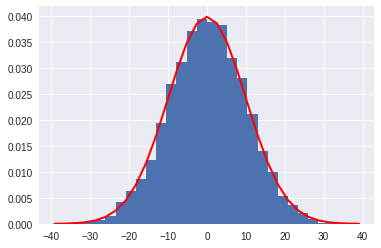

In [47]:
#准备噪声数据
mu, sigma = 0, 10
noise = np.ones((7840,10000),dtype=np.float)
for n in range (7840):
    noise[n] = np.random.normal(mu, sigma, 10000)
count, bins, ignored = plt.hist(noise[50], 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2) ),linewidth=2, color='r')
intensity=5
plt.show()
noise=noise.reshape(10,28,28,10000)

Generating data
data1 done


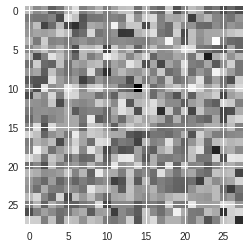

In [48]:
#将噪声叠加到同色图
def show(img):
    plt.imshow(img.reshape((28,28)))
    
print('Generating data')
Z=np.ones((10,10000,28,28),dtype=np.float)
for i in range(10):
    Z[i]=Z[i]*i*20
    for l in range(10000):
        for j in range(28):
            for k in range(28):
                Z[i,l,j,k]+=noise[i,j,k,l]*intensity/sigma;
print('data1 done')

print(Z[1,500])
show(Z[1,500])
Z= Z.reshape(100000, 28, 28)
Z= torch.from_numpy(Z.reshape(-1, 1, 28, 28))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


Generating data
data2 done
[[-3.83137749e+00  1.15828481e+00 -7.69169613e-01  6.30320365e+00
   3.65983183e+00 -3.20553713e+00 -9.30155922e+00  2.37662397e+00
   1.35829187e-02 -3.04651205e+00  2.41943684e+00 -1.26761365e+00
  -4.58783344e+00 -5.20630762e+00  4.40333879e+00 -2.52009817e+00
   3.39614675e+00  5.45080110e+00 -6.42756696e+00  8.06651265e+00
   1.86007791e+00 -4.29914704e+00 -2.45996009e+00  5.64379849e+00
   3.40214294e+00  8.18578257e+00  5.27543276e+00  8.32293428e+00]
 [ 2.90493873e+00  3.64405071e+00  3.69835716e+00  2.13126737e+00
   8.55505280e+00 -9.48564803e+00 -5.11624212e+00  7.68819240e+00
   3.81790930e+00  3.46460708e+00  2.55841600e+00  2.00825584e+00
   3.19050712e+00 -8.76084904e+00  1.73496726e-01 -7.18888794e+00
  -8.67396101e+00  2.35479490e+00 -2.20990378e+00 -1.61261392e+00
  -3.25229274e+00  9.89772946e+00 -8.19100989e-01 -3.58794340e+00
   1.80017572e+00  2.69486840e+00  3.91037138e+00 -1.77046208e-01]
 [ 5.90224276e-01 -4.34827165e+00  9.06217956e+

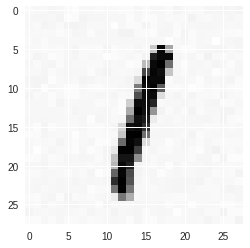

In [49]:
#将噪声叠加到测试数据
#yt = torch.from_numpy(yt.astype(float))
X, y, Xt, yt = get_data()
print('Generating data')
ZZ=np.ones((10,10000,28,28),dtype=np.float)
ZZori=np.ones((10,28,28),dtype=np.float)
for i in range(10):
    for l in range(10000):
        for j in range(28):
            for k in range(28):
                ZZ[i,l,j,k]=Xt[i,j,k]+noise[i,j,k,l]*intensity/sigma;
                ZZori[i,j,k]=Xt[i,j,k];
print('data2 done')

print(ZZ[5,500])
show(ZZ[5,500])
ZZ= ZZ.reshape(100000, 28, 28)
yt = torch.from_numpy(yt.astype(float))
ZZ= torch.from_numpy(ZZ.reshape(-1, 1, 28, 28))
ZZori= torch.from_numpy(ZZori.reshape(-1, 1, 28, 28))

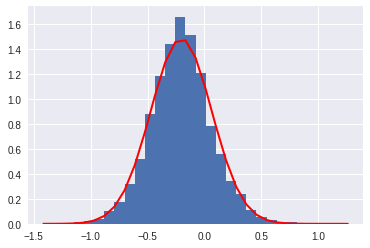

-0.20397851597964764    0.2689202703723235


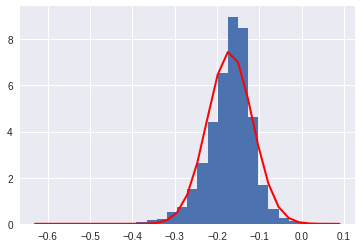

-0.1698405198764056    0.053359432801937993


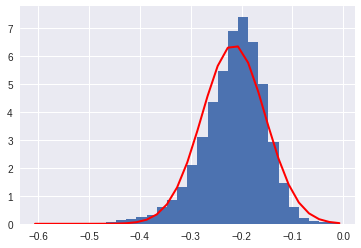

-0.21569686254262924    0.06220782662432117


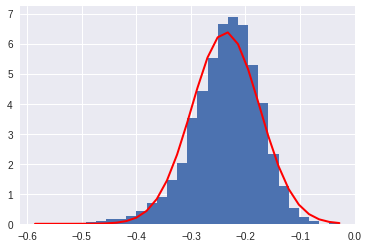

-0.23622349750101565    0.062477958552309844


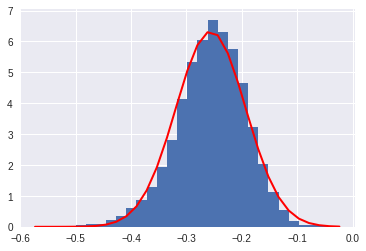

-0.25604110646396877    0.06306562244272951


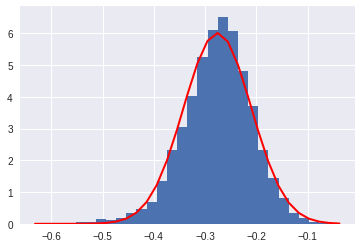

-0.2760594960425049    0.06629792049555196


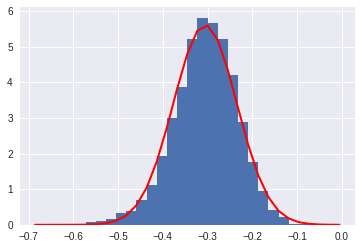

-0.3056470229409635    0.071127802396661


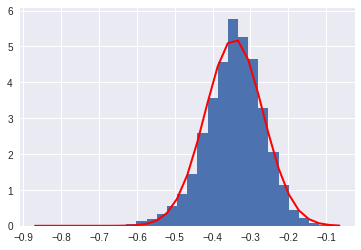

-0.34339655002653596    0.07657831812312721


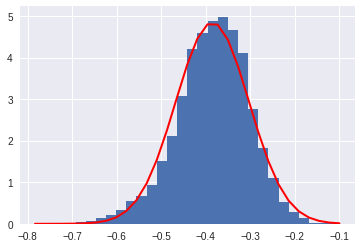

-0.38485674155876043    0.08239536938983785


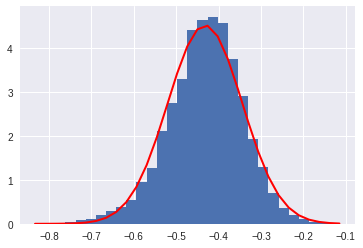

-0.43208098502755166    0.08813455385333442


In [50]:
#对同色图进行实验
def exam():
    out=np.ones((10000,10),dtype=np.float)
    model.eval()
    for each_point in range(10):
        for each_sample in range(10000):
            sample_data = Variable(Z[each_point*10000+each_sample:each_point*10000+each_sample+1].clone(), volatile=True)
            sample_data = sample_data.type(torch.FloatTensor)
            if use_gpu:
                sample_data = sample_data.cuda()
            sample_out = model(sample_data)
            out[each_sample] = sample_out.data.cpu().numpy()
        mean = out[:,5].mean()
        std = out[:,5].std()
        count, bins, ignored = plt.hist(out[:,5], 30, normed=True)#输出分布图只画输出的第5维（整个输出是10维）
        plt.plot(bins, 1/(std * np.sqrt(2 * np.pi)) *np.exp( - (bins - mean)**2 / (2 * std**2) ),linewidth=2, color='r')
        plt.show()
        print(mean,"  ",std)
exam()

[[-32.247314   -8.581349    1.2747118  -9.33826   -11.9279    -37.04799
  -57.699898   51.50115   -38.299606   -5.7306185]]
ori: 
 7
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
    Variable containing:
 7
[torch.cuda.LongTensor of size 1 (GPU 0)]



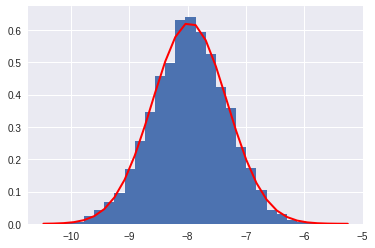

-7.962923009967804    0.6403837204154544
[-29.98349599  -7.96292301   1.36420389 -10.0286171  -11.60741492
 -34.99111759 -54.53309643  48.66930871 -36.10428994  -5.36363822]
noise: [48.66930871391296]    Variable containing:
 7
[torch.cuda.LongTensor of size 1 (GPU 0)]

[[  4.412962   -5.8918853  37.206505  -12.427958  -14.002415  -31.506578
   -7.2494764  -4.423806  -24.73242   -22.199852 ]]
ori: 
 2
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
    Variable containing:
 2
[torch.cuda.LongTensor of size 1 (GPU 0)]



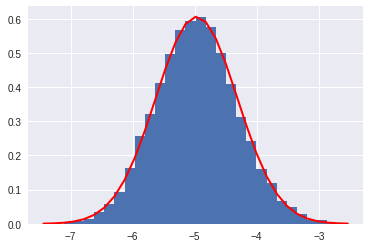

-4.970396398973465    0.6582442298280446
[  4.8939891   -4.9703964   35.00748699 -12.54807145 -12.08315432
 -29.86660128  -6.43300205  -4.40378382 -25.32251628 -21.00852308]
noise: [35.00748699092865]    Variable containing:
 2
[torch.cuda.LongTensor of size 1 (GPU 0)]

[[-44.814793   46.065647  -14.4246645 -41.29223   -13.312478  -31.851423
  -18.013117  -14.632761  -22.01767   -25.641685 ]]
ori: 
 1
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
    Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]



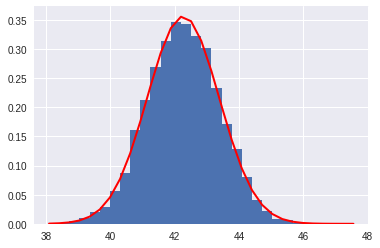

42.266749126815796    1.1202150855394803
[-41.93160559  42.26674913 -13.73470174 -37.80445795 -12.66087417
 -27.72024108 -17.246833   -14.20759383 -22.1732016  -23.7529077 ]
noise: [42.266749126815796]    Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

[[ 35.3274   -27.974241 -11.80655  -26.237015 -43.783024 -18.960741
  -11.462903  -8.308491 -10.739206 -16.357658]]
ori: 
 0
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
    Variable containing:
 0
[torch.cuda.LongTensor of size 1 (GPU 0)]



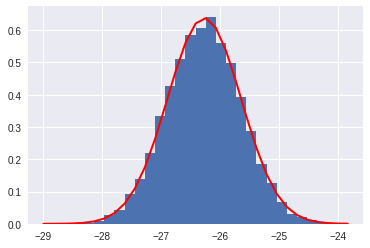

-26.270998844146728    0.6253106001817156
[ 33.68337658 -26.27099884 -11.56227924 -25.02495451 -42.13418622
 -17.84298237 -11.68275554  -6.26939308 -12.37182885 -14.63534992]
noise: [33.68337658138275]    Variable containing:
 0
[torch.cuda.LongTensor of size 1 (GPU 0)]

[[-22.612509   -14.670223   -29.637096   -22.834929    24.025164
  -17.742567   -13.476425   -11.509045   -11.1895       0.23117782]]
ori: 
 4
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
    Variable containing:
 4
[torch.cuda.LongTensor of size 1 (GPU 0)]



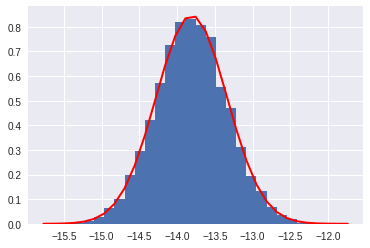

-13.809824262237548    0.47116081997518644
[-20.01764241 -13.80982426 -26.2636164  -19.77899731  21.59084204
 -16.114609   -13.13688908  -9.22290104 -10.01324231   2.62113686]
noise: [21.590842044067383]    Variable containing:
 4
[torch.cuda.LongTensor of size 1 (GPU 0)]

[[-48.46164   47.65551  -20.169996 -42.265358 -16.818785 -32.10404
  -21.66961  -13.91817  -22.853832 -23.22706 ]]
ori: 
 1
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
    Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]



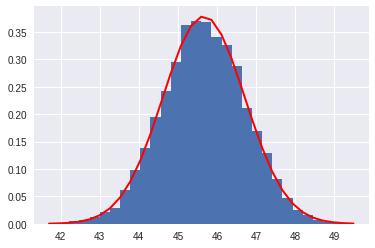

45.66084042778015    1.0532794394860785
[-48.07843698  45.66084043 -19.30134865 -40.25293763 -16.64834641
 -28.93658735 -20.83058394 -14.631148   -24.15258624 -22.9244679 ]
noise: [45.66084042778015]    Variable containing:
 1
[torch.cuda.LongTensor of size 1 (GPU 0)]

[[-26.387846  -12.42373   -12.865339  -16.97381    18.557945   -5.224591
  -10.21058    -7.6660566  -8.140574    2.7114725]]
ori: 
 4
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
    Variable containing:
 4
[torch.cuda.LongTensor of size 1 (GPU 0)]



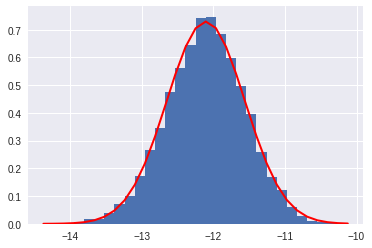

-12.104299083423614    0.546868884054982
[-23.9625893  -12.10429908 -12.41812908 -14.42913221  16.55631303
  -4.21589824  -8.34896269  -6.98250721  -7.22583327   1.01401873]
noise: [16.55631302804947]    Variable containing:
 4
[torch.cuda.LongTensor of size 1 (GPU 0)]

[[ -7.55247    -23.707151   -14.44328      0.5246196   -0.33690137
   -0.5564705  -14.169149    -9.737076     0.951084    20.589668  ]]
ori: 
 9
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
    Variable containing:
 9
[torch.cuda.LongTensor of size 1 (GPU 0)]



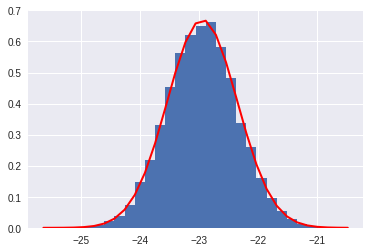

-22.947879988670348    0.5953402312554751
[ -6.28942172 -22.94787999 -14.56412113   1.03528779  -1.8450514
  -2.27024572 -15.27600306  -9.31949595   0.96115569  19.71874375]
noise: [19.718743750572205]    Variable containing:
 9
[torch.cuda.LongTensor of size 1 (GPU 0)]

[[-35.557323  -26.735447  -43.464962  -14.267238  -30.971842   41.126987
   -9.667468  -17.852026   -7.0670643  -5.7474213]]
ori: 
 5
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
    Variable containing:
 5
[torch.cuda.LongTensor of size 1 (GPU 0)]



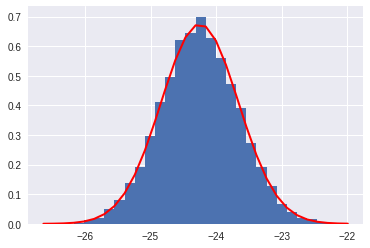

-24.248900782394408    0.5915273047338377
[-35.47573736 -24.24890078 -39.60911339 -13.336447   -28.87688414
  37.75867658  -9.7099141  -15.78327237  -7.09803037  -4.21545708]
noise: [37.75867657585144]    Variable containing:
 5
[torch.cuda.LongTensor of size 1 (GPU 0)]

[[-27.383091  -22.567627  -20.041302   -9.557713   -1.1487352  -7.5291457
  -35.57952     8.856948   -8.769423   29.07412  ]]
ori: 
 9
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
    Variable containing:
 9
[torch.cuda.LongTensor of size 1 (GPU 0)]



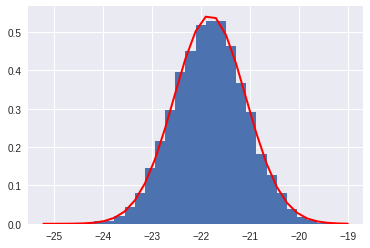

-21.821868110656737    0.7337639183907565
[-25.6829677  -21.82186811 -18.89061641  -7.6949189   -0.78804614
  -7.23974101 -36.72930462   9.03205443  -8.71152023  29.69312646]
noise: [29.693126456260682]    Variable containing:
 9
[torch.cuda.LongTensor of size 1 (GPU 0)]



In [51]:
#对实际样本进行实验
import heapq 

def exam():
    mean=np.ones(10)
    std=np.ones(10)
    out=np.ones((10000,10),dtype=np.float)
    model.eval()
    for each_point in range(10):
        #计算原本值
        ori_data = Variable(ZZori[each_point:each_point+1].clone(), volatile=True)
        ori_data = ori_data.type(torch.FloatTensor)
        sample_label = Variable(yt[each_point:each_point+1].clone())
        sample_label = sample_label.type(torch.LongTensor)
        if use_gpu:
            sample_label = sample_label.cuda()
            ori_data = ori_data.cuda()
        ori_out = model(ori_data)
        pred = ori_out.data.max(1, keepdim=True)[1]
        ori_out = ori_out.data.cpu().numpy()
        print(ori_out)
        print("ori:",pred,"  ",sample_label)
        #计算噪声组
        for each_sample in range(10000):
            sample_data = Variable(ZZ[each_point*10000+each_sample:each_point*10000+each_sample+1].clone(), volatile=True)
            sample_data = sample_data.type(torch.FloatTensor)
            if use_gpu:
                sample_data = sample_data.cuda()
            sample_out = model(sample_data)
            out[each_sample] = sample_out.data.cpu().numpy()
        for tags in range(10):
            mean[tags] = out[:,tags].mean()
            std [tags] = out[:,tags].std()
        count, bins, ignored = plt.hist(out[:,1], 30, normed=True)#输出分布图只画输出的第1维（整个输出是10维）
        plt.plot(bins, 1/(std[1] * np.sqrt(2 * np.pi)) *np.exp( - (bins - mean[1])**2 / (2 * std[1]**2) ),linewidth=2, color='r')
        plt.show()
        print(mean[1],"  ",std[1])
        print(mean)
        pred = heapq.nlargest(1,mean)
        print("noise:",pred,"  ",sample_label)
exam()

In [58]:
print(model)
params=model.state_dict() 
for k,v in params.items():
    print(k)    #打印网络中的变量名
print("conv1.weight",params['conv1.weight'].size(),params['conv1.weight'])   #打印conv1的weight
print("conv1.bias",params['conv1.bias'].size(),params['conv1.bias'])   #打印conv1的bias  
print("conv2.weight",params['conv2.weight'].size(),params['conv2.weight'])   #打印conv1的weight
print("conv2.bias",params['conv2.bias'].size(),params['conv2.bias'])   #打印conv1的bias  
print("fc1.weight",params['fc1.weight'].size(),params['fc1.weight'])   #打印conv1的weight
print("fc1.bias",params['fc1.bias'].size(),params['fc1.bias'])   #打印conv1的bias  
print("fc2.weight",params['fc2.weight'].size(),params['fc2.weight'])   #打印conv1的weight
print("fc2.bias",params['fc2.bias'].size(),params['fc2.bias'])   #打印conv1的bias  
print("fc3.weight",params['fc3.weight'].size(),params['fc3.weight'])   #打印conv1的weight
print("fc3.bias",params['fc3.bias'].size(),params['fc3.bias'])   #打印conv1的bias

LeNet5(
  (conv1): Conv2d (1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d (6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)
conv1.weight
conv1.bias
conv2.weight
conv2.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
fc3.weight
fc3.bias
conv1.weight torch.Size([6, 1, 5, 5]) 
(0 ,0 ,.,.) = 
 -0.0250  0.1207  0.1055  0.1101 -0.0352
  0.0028  0.0420 -0.0993  0.1085  0.1265
 -0.0118  0.1727  0.0733 -0.1279  0.1613
 -0.2127 -0.1007 -0.0469  0.0407 -0.0986
 -0.0198  0.0531  0.0080 -0.0974 -0.0360

(1 ,0 ,.,.) = 
  0.1199 -0.0714 -0.1394  0.0653  0.1349
  0.1412  0.0756  0.0060  0.0296 -0.0180
 -0.0567  0.0096  0.0576 -0.1561 -0.1288
  0.0241  0.1017 -0.0103  0.0188 -0.1488
 -0.1296  0.0208 -0.0281  0.0169 -0.0116

(2 ,0 ,.,.) = 
  0.1117  0.1840  0.1363 -0.1612 -0.0939
  0.1183 -0.0580 -0.1964 -0.0820  0.0096
 -0.0967 -0.1850 